# Algorithm

Tentative strategic plan (to be verified in the backtesting algo):

1. Select only equitys which have not have negative earnings in the last 15 years.
2. Select only equitys with an equity ratio of >25%
3. Select RoE in the upper half of all (more than 60% or 70% depending on the outcome of the backtesting)
4. Reasonable earnings growth history
5. Optional point: price-book-ratio<1
6. P/E ratio not more than 10% above the min historical P/E ratio
7. P/E ratio (historical over past three years) < 20
8. Positive reaction to quartery report
9. [+1/0] if rating is negative/positive
10. EBT margin >12%

In [39]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

cnx        = sqlite3.connect('database/stocks_main.db')
xetra      = pd.read_sql("SELECT * FROM XETRA;", cnx)

In [508]:
def get_datetime(inputobj):
    return dt.datetime.date(inputobj)

def convert_sql_date_to_datetime_date(string):
    return dt.datetime.strptime(string,'%Y-%m-%d').date()

class quotes:
    def __init__(self):
        pass

    def _get_lastprice(self):
        self.lastquote = self.quote[self.quote.date==self.quote.date.max()].close.values
    
    def _get_quote(self):
        # load the entries for the current stock from the database
        cnx         = sqlite3.connect('database/stocks_quotes.db')
        sql         = pd.read_sql_query("SELECT * FROM quotes WHERE isin = '{0}';".format(self.isin), cnx)
        cnx.close()    
        if sql is not None:
            sql['date'] = sql.date.apply(convert_sql_date_to_datetime_date)
        self.quote  = sql
        
        self._get_lastprice()
        
    def get_highwatermark(self):
        '''Calculate the high watermark of the dataset'''
        hw = []
        mark = 0
        for i,j in self.quote.iterrows():
            if j['close']>mark and j['close']>0:
                mark = j['close']
            hw.append(mark)
        self.quote = self.quote.assign(highwatermark=pd.Series(hw))
        
class fundamentals:
    def __init__(self):
        pass

    def _get_keyratios(self):
        # load the entries for the current stock from the database
        cnx         = sqlite3.connect('database/stocks_keyratios.db')
        sql         = pd.read_sql_query("SELECT * FROM fundamentals WHERE ISIN = '{0}';".format(self.isin), cnx)
        cnx.close()    
        sql = sql.sort_values(by='year',ascending=False)
        sql = sql.reset_index(drop=True)
        
        self.keyratios = sql
        
    def _get_pe_for_year(self, pe_year, month=4, day=1, detailed=False):
        '''Get the price/earnings ratio for every day of the subsequent year'''
        # get the min/max date for quotes
        mindate = dt.date(pe_year+1, month, day)                                             
        maxdate = dt.date(pe_year+2, month, day)

        # get the eps for the year under consideration
        eps   = self.keyratios[self.keyratios.year==pe_year]['EarningsPerShare'].values[0]

        # extract the quote 
        quote = self.quote[(self.quote.date>mindate) & (self.quote.date<maxdate)]

        quote = quote.assign(pe=(quote.close/eps).values)
        quote = quote.assign(eps=np.ones(len(quote))*eps)

        if detailed:
            return quote
        return quote[['date','close','pe', 'eps']]
    
    def _get_all_pe(self,detailed=False):
        '''Creates an object with the price to earnings ratio for every day of all years'''
        finalquote = None
        year = self.keyratios.year.min()+1 

        for _ in range(len(self.keyratios.year)-1):
            if finalquote is None:
                finalquote = get_pe_for_year(year,detailed=detailed)
            else:
                finalquote = finalquote.append(get_pe_for_year(year,detailed=detailed),ignore_index=True)
            year+=1
        self.per_table = finalquote

In [525]:
class algo:
    def _initialize_algo(self):
        self.cols         = ['Name','ISIN', 'Parameter', 'Value', 'Point']
        self.quant_result = pd.DataFrame(columns=self.cols)
    
    def _add_result(self,para,val,point):
        '''Add the result of the individual analysis to the total result.'''
        res = [[self.name, self.isin, para, val, point]]
        self.quant_result = self.quant_result.append(pd.DataFrame(res,columns=self.cols),ignore_index=True)
    
    def get_best_column(self,*args):
        '''If multiple columns can be used for the analysis, select the column with the best data quality'''
        vals = args

        _length = []
        for _i, _s in enumerate(vals):
            _length.append([_i,len(self.keyratios[self.keyratios[_s].isnull()])])
        _length = np.array(_length)
        _bestcol = vals[_length[_length[:,1].argmin()][0]]

        return _bestcol
    
    def positive_earnings(self,verbose=False):
        
        _col = self.get_best_column('NetIncome','EarningsPerShare')
        if (self.keyratios[_col]<0).any():
            val   = -1
            point = -1
        else:
            val   = 1
            point = 1 
        self._add_result('OnlyPositiveEarnings', _col, point)
        
    def per_vs_historic_per(self,verbose=False):
        self._get_all_pe()
        
        _current = self.per_table[self.per_table.date == self.per_table.date.max()].pe.values[0]
        _limit1  = self.per_table.pe.quantile(0.33)
        _limit2  = self.per_table.pe.quantile(0.66)

        if _current<_limit1:
            point = 1
        elif _current>_limit2: 
            point = -1
        else:
            point = 0
            
        self._add_result('EPSvsHistoricEPS', '{0:0.1f}/{1:0.1f}: {2:0.1f}'.format(_limit1, _limit2, _current), point)
    
    def historic_roe(self):
        '''Checks if the historic ROE was never below 20%'''
        _roe = self.keyratios['ReturnonEquity'][1:]
        _roe = _roe[_roe>0]

        if not (_roe<20).any():
            point = 1
        elif not (_roe<10).any():
            point = 0
        else:
            point = -1
            
        _value = _roe.mean()
        self._add_result('HistoricROE', '{0:0.1f}'.format(_value), point)  
        
        
    def present_roe(self):
        '''Check if ROE is above 20%'''
        _roe = self.keyratios['ReturnonEquity']
        _val = _roe[0]

        if not (_val<20).any():
            point = 1
        elif not (_val<10).any():
            point = 0
        else:
            point = -1
            
        self._add_result('PresentROE', '{0:0.1f}'.format(_val), point)  

        
    def present_ebtmargin(self):
        '''Check if EBT margin is above 12%'''
        _ebtm = self.keyratios['EBTMargin']
        _val  = _ebtm[0]

        if _val>12:
            point = 1
        elif _val<6:
            point = -1
        else:
            point = 0
            
        self._add_result('EBTMargin', '{0:0.1f}'.format(_val), point)  
        

In [526]:
class time:
    '''Make the analysis for today a special case of backtesting'''
    
    def _assign_pointintime(self, day):
        # self.bdate = the backtesting date
        self.day      = day
        self.bdate    = self.quote.date[0] + dt.timedelta(days=self.day)
        self.quote    = self.quote[self.quote.date < self.bdate]
        
        if self.bdate.month<4:
            _max_keyratio_year = self.bdate.year - 2 
        else:
            _max_keyratio_year = self.bdate.year - 1

        self.keyratios = self.keyratios[self.keyratios['year'] < _max_keyratio_year]

In [527]:
class stocks(quotes,fundamentals,algo,time):
    def __init__(self,stocklist,index=0,ISIN=None,verbose=False):
        
        self._initialize_algo()
        
        self.list    = stocklist
        self.verbose = verbose

        if ISIN:
            self.switch_isin(ISIN)
        else:
            self.switch_index(index)
        self._update_tables()
            
    def switch_isin(self,isin):
        df         = self.list[self.list.ISIN==isin]
        self.index = df.index[0]
        self.name, self.isin, self.ticker = np.array(df)[0]
        self._update_tables()
        
    def switch_index(self,index):
        self.index = index
        df         = self.list[self.list.index==index]
        self.name, self.isin, self.ticker = np.array(df)[0]
        
    def switch_next(self):
        try:
            self.switch_index(self.index+1)
            self._update_tables()
        except IndexError:
            pass

    def _update_tables(self):
        self._get_keyratios()
        self._get_quote()
        
    def update_time(self,day):
        '''This function resets the data such that only the data known at the 
        selected moment in time is available. '''
        self._update_tables()        
        self._assign_pointintime(day)


# Positive Earnings in the last years

In [528]:
s = stocks(xetra,verbose=True)
s.switch_isin('DE0005790430')

In [529]:
s.positive_earnings()

In [530]:
s.quant_result

,Name,ISIN,Parameter,Value,Point
0,FUCHS PETROL.SE VZO O.N.,DE0005790430,OnlyPositiveEarnings,EarningsPerShare,1.0


At the end of the analysis for each stock write data to sql, one table with detailed data, one table with summary

# Historical P/E ratio

In [531]:
s.per_vs_historic_per()

In [532]:
s.quant_result

,Name,ISIN,Parameter,Value,Point
0,FUCHS PETROL.SE VZO O.N.,DE0005790430,OnlyPositiveEarnings,EarningsPerShare,1.0
1,FUCHS PETROL.SE VZO O.N.,DE0005790430,EPSvsHistoricEPS,14.2/20.2: 25.4,-1.0


In [300]:
s._get_all_pe()

In [301]:
histpe.describe()

,close,pe,eps
count,4035.000000,4035.000000,4190.000000
mean,16.936468,17.107795,0.841654
std,14.363117,5.546387,0.562407
min,0.962940,5.021649,0.120000
25%,4.505830,13.139795,0.270000
50%,11.116700,16.750001,0.770000
75%,30.872499,21.761437,1.450000
max,51.570000,28.662420,1.860000


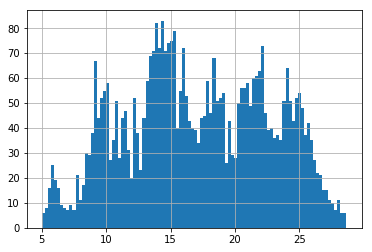

In [303]:
s.per_table.pe.hist(bins=100)
plt.show()

# Return on Equity

In [533]:
s.historic_roe()

In [534]:
s.quant_result

,Name,ISIN,Parameter,Value,Point
0,FUCHS PETROL.SE VZO O.N.,DE0005790430,OnlyPositiveEarnings,EarningsPerShare,1.0
1,FUCHS PETROL.SE VZO O.N.,DE0005790430,EPSvsHistoricEPS,14.2/20.2: 25.4,-1.0
2,FUCHS PETROL.SE VZO O.N.,DE0005790430,HistoricROE,31.5,1.0


In [535]:
s.present_roe()

In [536]:
s.quant_result

,Name,ISIN,Parameter,Value,Point
0,FUCHS PETROL.SE VZO O.N.,DE0005790430,OnlyPositiveEarnings,EarningsPerShare,1.0
1,FUCHS PETROL.SE VZO O.N.,DE0005790430,EPSvsHistoricEPS,14.2/20.2: 25.4,-1.0
2,FUCHS PETROL.SE VZO O.N.,DE0005790430,HistoricROE,31.5,1.0
3,FUCHS PETROL.SE VZO O.N.,DE0005790430,PresentROE,22.8,1.0


# Historic earnings growth

In [455]:
_col = s.get_best_column('NetIncome','EarningsPerShare')

In [463]:
_three_year_earnings_growth = -s.keyratios[_col].diff()[0:4]

In [467]:
if not (_three_year_earnings_growth<0).any():
    point = 1

In [469]:
_three_year_earnings_growth.mean()

0.11000000000000003

expected earnings in 10 years

In [518]:
extrapolated_eps = 1.86*(1.11)**10

In [519]:
s.lastquote[0]/extrapolated_eps

8.9608230162290994

# EBT margin

In [537]:
s.present_ebtmargin()

In [538]:
s.quant_result

,Name,ISIN,Parameter,Value,Point
0,FUCHS PETROL.SE VZO O.N.,DE0005790430,OnlyPositiveEarnings,EarningsPerShare,1.0
1,FUCHS PETROL.SE VZO O.N.,DE0005790430,EPSvsHistoricEPS,14.2/20.2: 25.4,-1.0
2,FUCHS PETROL.SE VZO O.N.,DE0005790430,HistoricROE,31.5,1.0
3,FUCHS PETROL.SE VZO O.N.,DE0005790430,PresentROE,22.8,1.0
4,FUCHS PETROL.SE VZO O.N.,DE0005790430,EBTMargin,16.3,1.0


In [523]:
s.keyratios['EBTMargin']

0     16.28
1     16.26
2     16.62
3     16.96
4     16.00
5     15.73
6     16.82
7     14.68
8     11.68
9     13.67
10    11.29
11      NaN
12      NaN
13      NaN
14      NaN
15      NaN
16      NaN
17      NaN
Name: EBTMargin, dtype: float64

# Calculate maximum drawdown 

In [86]:
s.get_highwatermark()

In [87]:
hwratio = s.quote.close/s.quote.highwatermark

In [88]:
hwratio.describe()

count    4360.000000
mean        0.880524
std         0.132514
min         0.309044
25%         0.843490
50%         0.914717
75%         0.972077
max         1.000000
dtype: float64

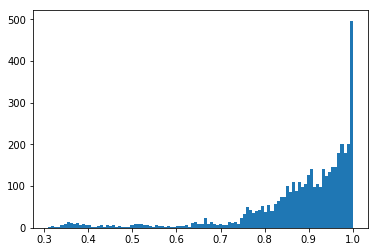

In [89]:
plt.hist(hwratio[hwratio>0],bins=100)
plt.show()

# Backtesting

In [260]:
s.keyratios

,name,ISIN,currency,year,Shares,Revenue,NetIncome,EBTMargin,EarningsPerShare,Dividends,...,FreeCashFlowPerShare,WorkingCapital,COGS,TaxRate,NetMargin,AssetTurnoverAverage,ReturnonAssets,FinancialLeverageAverage,ReturnonInvestedCapital,InterestCoverage
0,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2006,156.0,1323.0,96.0,11.29,0.62,0.13,...,NaN,169.0,64.72,34.94,7.30,1.93,14.08,2.25,29.47,25.10
1,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2007,154.0,1365.0,119.0,13.67,0.77,0.17,...,0.47,154.0,62.70,35.57,8.76,1.96,17.14,2.13,36.08,17.67
2,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2008,147.0,1394.0,109.0,11.68,0.74,0.25,...,0.82,121.0,64.98,32.25,7.85,1.96,15.42,2.24,28.76,21.87
3,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2009,142.0,1178.0,120.0,14.68,0.84,0.27,...,0.41,239.0,61.20,29.79,10.25,1.63,16.67,1.90,27.68,35.58
4,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2010,142.0,1458.0,170.0,16.82,1.20,0.29,...,1.00,286.0,61.13,30.07,11.70,1.78,20.82,1.64,33.91,82.80
5,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2011,142.0,1652.0,182.0,15.73,1.28,0.45,...,0.94,315.0,63.39,29.66,10.93,1.77,19.37,1.51,29.65,97.41
6,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2012,142.0,1819.0,206.0,16.00,1.45,0.50,...,0.82,395.0,63.39,28.86,11.36,1.73,19.69,1.42,28.27,NaN
7,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2013,142.0,1831.0,218.0,16.96,1.53,0.65,...,1.02,426.0,62.33,29.64,11.91,1.61,19.21,1.36,26.45,NaN
8,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2014,139.0,1866.0,220.0,16.62,1.57,0.70,...,1.16,458.0,62.85,29.09,11.76,1.53,18.01,1.40,24.51,NaN
9,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2015,139.0,2079.0,236.0,16.26,1.69,0.77,...,1.58,430.0,61.95,30.22,11.34,1.50,17.05,1.39,23.63,NaN


In [265]:
s.update_time(1120)
print(s.bdate)

2002-04-09


In [266]:
s.keyratios

,name,ISIN,currency,year,Shares,Revenue,NetIncome,EBTMargin,EarningsPerShare,Dividends,...,FreeCashFlowPerShare,WorkingCapital,COGS,TaxRate,NetMargin,AssetTurnoverAverage,ReturnonAssets,FinancialLeverageAverage,ReturnonInvestedCapital,InterestCoverage
16,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2000,NaN,NaN,NaN,NaN,0.13,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,1999,NaN,NaN,NaN,NaN,0.13,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [267]:
s.update_time(1100)
print(s.bdate)

2002-03-20


In [268]:
s.keyratios

,name,ISIN,currency,year,Shares,Revenue,NetIncome,EBTMargin,EarningsPerShare,Dividends,...,FreeCashFlowPerShare,WorkingCapital,COGS,TaxRate,NetMargin,AssetTurnoverAverage,ReturnonAssets,FinancialLeverageAverage,ReturnonInvestedCapital,InterestCoverage
17,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,1999,NaN,NaN,NaN,NaN,0.13,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
